In [1]:
import os
import sys
import glob

sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand")
sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D")

from dataloader_ann import HandArmLandmarksDataset_ANN

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from datetime import datetime

import open3d as o3d
from utilities import convert_to_left_shoulder_coord
import time

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from csv_writer import fusion_csv_columns_name
import matplotlib.pyplot as plt

import joblib
import sklearn

import json

import math
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


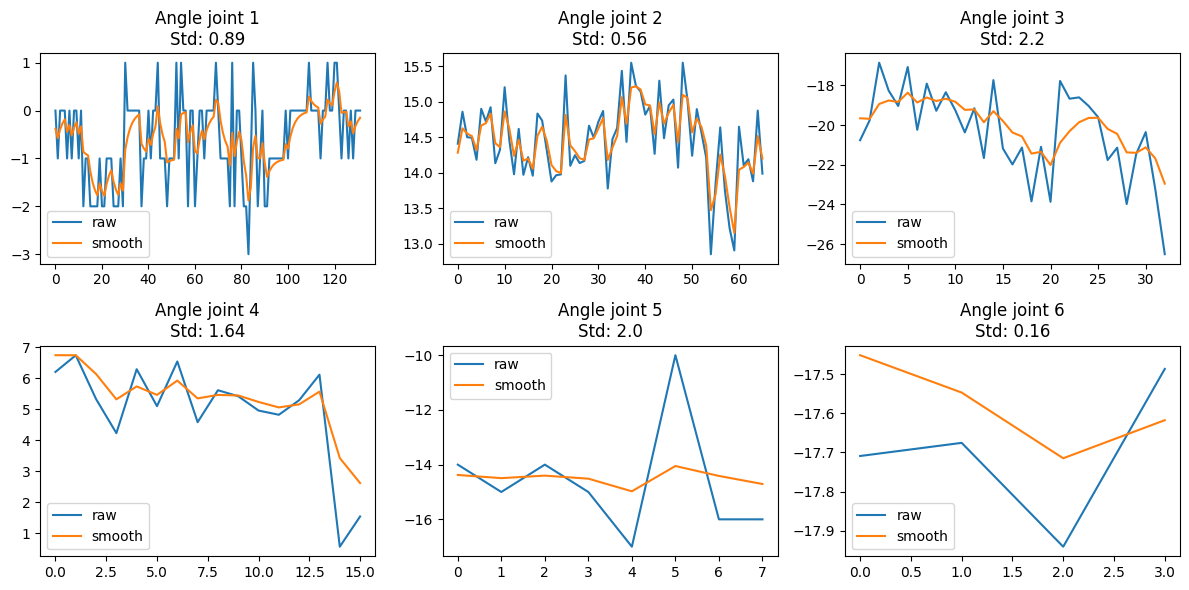

In [2]:
angles_df = pd.read_csv("/home/giakhang/dev/pose_sandbox/data/2024-09-30/2024-09-30-17:09/arm_angle_2024-09-30-17:09.csv")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    total_rows = len(angles_df)
    start_idx = total_rows // 4  
    end_idx = start_idx + total_rows // 2  
    angles_df = angles_df.iloc[start_idx:end_idx]
    raw_joint_i_angles = angles_df.iloc[:, i+2].values
    smooth_joint_i_angles = angles_df.iloc[:, i+2+6].values
    ax.plot(raw_joint_i_angles)
    ax.plot(smooth_joint_i_angles)
    title = "Angle joint {}\nStd: {}".format(i + 1, round(raw_joint_i_angles.std(), 2))
    ax.set_title(title)
    ax.legend(['raw', 'smooth'])

plt.tight_layout()
plt.show()

In [3]:
joint1_max_velo = 1.5184 * (180 / math.pi)
joint2_max_velo = 1.5184 * (180 / math.pi)
joint3_max_velo = 2.1074 * (180 / math.pi)
joint4_max_velo = 2.1074 * (180 / math.pi)
joint5_max_velo = 3.3719 * (180 / math.pi)
joint6_max_velo = 3.3719 * (180 / math.pi)

In [4]:
joint1_max_acce = 2 * (180 / math.pi)
joint2_max_acce = 2 * (180 / math.pi)
joint3_max_acce = 4 * (180 / math.pi)
joint4_max_acce = 4 * (180 / math.pi)
joint5_max_acce = 6 * (180 / math.pi)
joint6_max_acce = 6 * (180 / math.pi)

In [5]:
angles_df = pd.read_csv("/home/giakhang/dev/pose_sandbox/data/2024-09-30/2024-09-30-17:09/arm_angle_2024-09-30-17:09.csv")

In [6]:
class Angle_PID:
    def __init__(self, Kp, Ki, Kd, setpoint, v_max, a_max, dt):
        self._Kp = Kp
        self._Ki = Ki
        self._Kd = Kd
        self._setpoint = setpoint
        self._v_max = v_max
        self._a_max = a_max
        self._error_last = 0
        self._integral = 0
        self._dt = dt
        self._v_current = 0

    def update_setpoint(self, setpoint):
        self._setpoint = setpoint

    def update(self, p_current):
        error = self._setpoint - p_current
        self._integral = (self._integral + error) * self._dt
        derivative = (error - self._error_last) / self._dt
        pid_value = self._Kp * error + self._Ki * self._integral + self._Kd * derivative

        a_current = max(-self._a_max, min(self._a_max, pid_value))
        self._v_current = max(-self._v_max, min(self._v_max, self._v_current + a_current * self._dt))
        p_next = p_current + self._v_current * self._dt

        self._error_last = error

        return p_next, a_current

# Tuning joint1

In [7]:
angles_j1_setpoint = angles_df["smooth_joint_1"].values

j1_Kp = 30
j1_Ki = 70
j1_Kd = 10
dt = 1 / 60

second = 10
fps_update = 60
fps_streaming = 5
loop_time = second * fps_update

current_frame = 0
setpoint = angles_j1_setpoint[current_frame]
j1_pid = Angle_PID(Kp=j1_Kp, Ki=j1_Ki, Kd=j1_Kd, setpoint=setpoint,
    v_max=joint1_max_velo, a_max=joint1_max_acce, dt=dt)
j1_current = 0

j1_pos_history = []
j1_v_history = []
j1_a_history = []
setpoint_history = []
frames = []

count = 1

for i in range(loop_time):
    j1_next, j1_a_current = j1_pid.update(j1_current)
    j1_current = j1_next
    j1_pos_history.append(j1_current)
    j1_v_history.append(j1_pid._v_current)
    j1_a_history.append(j1_a_current)
    setpoint_history.append(j1_pid._setpoint)

    # Set new setpoint
    if count * dt >= 1 / fps_streaming:
        current_frame += 1
        setpoint = angles_j1_setpoint[current_frame]
        j1_pid.update_setpoint(setpoint)
        count = 1
    else:
        count += 1

    frames.append(current_frame)

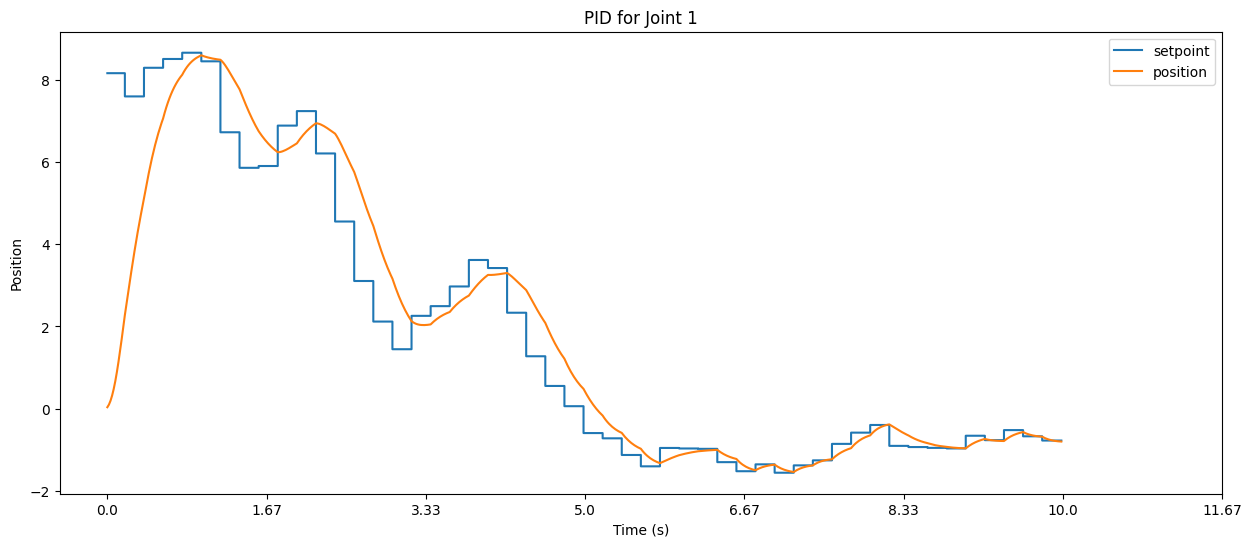

In [8]:
plt.figure(figsize=(15, 6))

sns.lineplot(data=setpoint_history, drawstyle="steps-pre", label="setpoint")
sns.lineplot(data=j1_pos_history, label='position')
#sns.lineplot(data=j1_v_history, label='velocity')
#sns.lineplot(data=j1_a_history, label='acceleration')

ticks, labels = plt.xticks()
plt.xticks(ticks=ticks[1:], labels=np.round(ticks[1:] * dt, 2))
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.legend()

plt.title("PID for Joint 1")
plt.show()

# Tuning joint 2

In [9]:
angles_j2_setpoint = angles_df["smooth_joint_2"].values

j2_Kp = 30
j2_Ki = 70
j2_Kd = 10
dt = 1 / 60

second = 10
fps_update = 60
fps_streaming = 5
loop_time = second * fps_update

current_frame = 0
setpoint = angles_j2_setpoint[current_frame]
j2_pid = Angle_PID(Kp=j2_Kp, Ki=j2_Ki, Kd=j2_Kd, setpoint=setpoint,
    v_max=joint2_max_velo, a_max=joint2_max_acce, dt=dt)
j2_current = 0

j2_pos_history = []
j2_v_history = []
j2_a_history = []
setpoint_history = []
frames = []

count = 1

for i in range(loop_time):
    j2_next, j2_a_current = j2_pid.update(j2_current)
    j2_current = j2_next
    j2_pos_history.append(j2_current)
    j2_v_history.append(j2_pid._v_current)
    j2_a_history.append(j2_a_current)
    setpoint_history.append(j2_pid._setpoint)

    # Set new setpoint
    if count * dt >= 1 / fps_streaming:
        current_frame += 1
        setpoint = angles_j2_setpoint[current_frame]
        j2_pid.update_setpoint(setpoint)
        count = 1
    else:
        count += 1

    frames.append(current_frame)

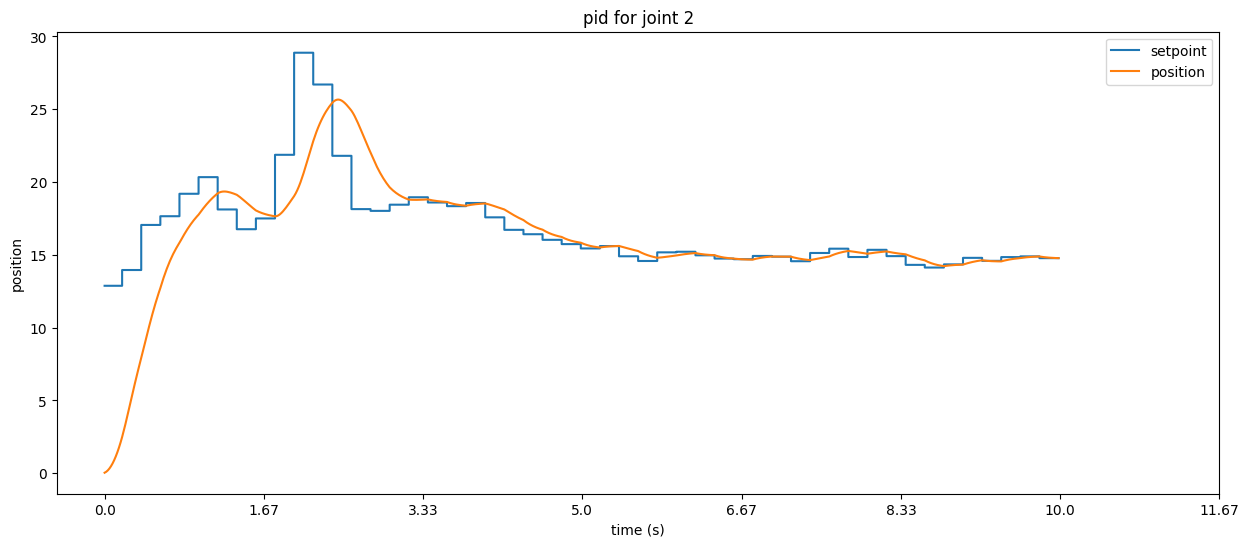

In [10]:
plt.figure(figsize=(15, 6))

sns.lineplot(data=setpoint_history, drawstyle="steps-pre", label="setpoint")
sns.lineplot(data=j2_pos_history, label='position')
#sns.lineplot(data=j2_v_history, label='velocity')
#sns.lineplot(data=j2_a_history, label='acceleration')

ticks, labels = plt.xticks()
plt.xticks(ticks=ticks[1:], labels=np.round(ticks[1:] * dt, 2))
plt.xlabel("time (s)")
plt.ylabel("position")
plt.legend()
plt.title("pid for joint 2")
plt.show()

# Tuning for Joint 3

In [11]:
angles_j3_setpoint = angles_df["smooth_joint_3"].values

j3_Kp = 40
j3_Ki = 70
j3_Kd = 15
dt = 1 / 60

second = 10
fps_update = 60
fps_streaming = 5
loop_time = second * fps_update

current_frame = 0
setpoint = angles_j3_setpoint[current_frame]
#setpoint = 5
j3_pid = Angle_PID(Kp=j3_Kp, Ki=j3_Ki, Kd=j3_Kd, setpoint=setpoint,
    v_max=joint3_max_velo, a_max=joint3_max_acce, dt=dt)
j3_current = 0

j3_pos_history = []
j3_v_history = []
j3_a_history = []
setpoint_history = []
frames = []

count = 1

for i in range(loop_time):
    j3_next, j3_a_current = j3_pid.update(j3_current)
    j3_current = j3_next
    j3_pos_history.append(j3_current)
    j3_v_history.append(j3_pid._v_current)
    j3_a_history.append(j3_a_current)
    setpoint_history.append(j3_pid._setpoint)

    # Set new setpoint
    if count * dt >= 1 / fps_streaming:
        current_frame += 1
        setpoint = angles_j3_setpoint[current_frame]
        j3_pid.update_setpoint(setpoint)
        count = 1
    else:
        count += 1

    frames.append(current_frame)

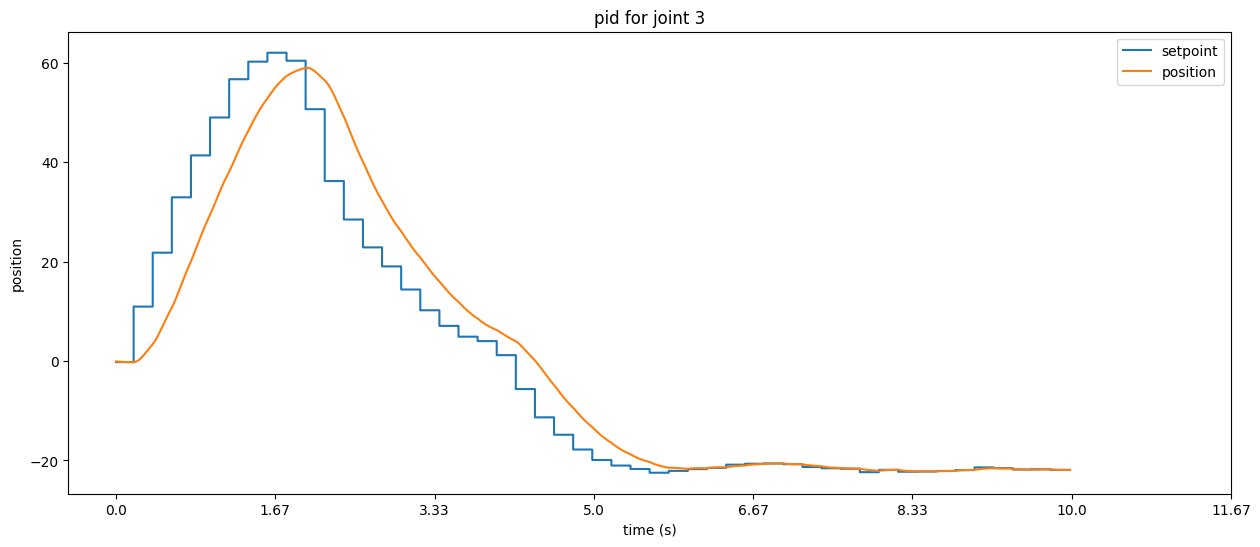

In [12]:
plt.figure(figsize=(15, 6))

sns.lineplot(data=setpoint_history, drawstyle="steps-pre", label="setpoint")
sns.lineplot(data=j3_pos_history, label='position')
#sns.lineplot(data=j3_v_history, label='velocity')
#sns.lineplot(data=j3_a_history, label='acceleration')

ticks, labels = plt.xticks()
plt.xticks(ticks=ticks[1:], labels=np.round(ticks[1:] * dt, 2))
plt.xlabel("time (s)")
plt.ylabel("position")
plt.legend()
plt.title("pid for joint 3")
plt.show()

# Tuning for Joint 4

In [33]:
angles_j4_setpoint = angles_df["smooth_joint_4"].values

j4_Kp = 40
j4_Ki = 70
j4_Kd = 15
dt = 1 / 60

second = 2
fps_update = 60
fps_streaming = 5
loop_time = second * fps_update

current_frame = 0
setpoint = angles_j4_setpoint[current_frame]
#setpoint = 180
j4_pid = Angle_PID(Kp=j4_Kp, Ki=j4_Ki, Kd=j4_Kd, setpoint=setpoint,
    v_max=joint4_max_velo, a_max=joint4_max_acce, dt=dt)
j4_current = 0

j4_pos_history = []
j4_v_history = []
j4_a_history = []
setpoint_history = []
frames = []

count = 1

for i in range(loop_time):
    j4_next, j4_a_current = j4_pid.update(j4_current)
    j4_current = j4_next
    j4_pos_history.append(j4_current)
    j4_v_history.append(j4_pid._v_current)
    j4_a_history.append(j4_a_current)
    setpoint_history.append(j4_pid._setpoint)

    # Set new setpoint
    if count * dt >= 1 / fps_streaming:
        current_frame += 1
        setpoint = angles_j4_setpoint[current_frame]
        j4_pid.update_setpoint(setpoint)
        count = 1
    else:
        count += 1

    frames.append(current_frame)

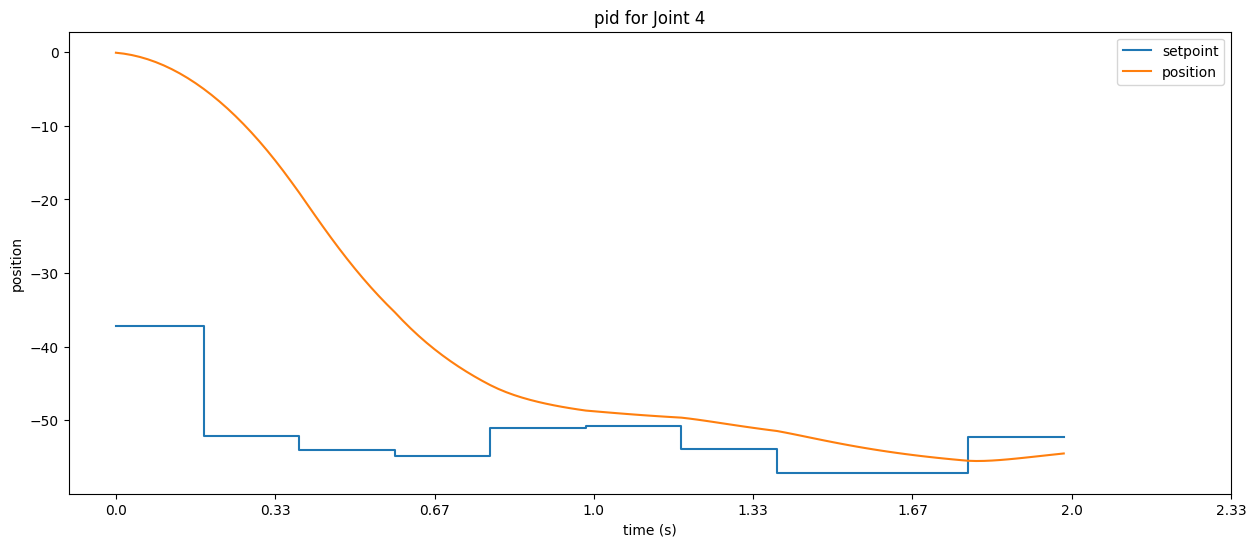

In [36]:
plt.figure(figsize=(15, 6))

sns.lineplot(data=setpoint_history, drawstyle="steps-pre", label="setpoint")
sns.lineplot(data=j4_pos_history, label='position')
#sns.lineplot(data=j4_v_history, label='velocity')
#sns.lineplot(data=j4_a_history, label='acceleration')

ticks, labels = plt.xticks()
plt.xticks(ticks=ticks[1:], labels=np.round(ticks[1:] * dt, 2))
plt.xlabel("time (s)")
plt.ylabel("position")
plt.legend()
plt.title("pid for Joint 4")
plt.show()

# Tuning for Joint 5

In [50]:
angles_j5_setpoint = angles_df["smooth_joint_5"].values

j5_Kp = 40
j5_Ki = 70
j5_Kd = 15
dt = 1 / 60

second = 10
fps_update = 60
fps_streaming = 5
loop_time = second * fps_update

current_frame = 0
setpoint = angles_j5_setpoint[current_frame]
#setpoint = 180
j5_pid = Angle_PID(Kp=j5_Kp, Ki=j5_Ki, Kd=j5_Kd, setpoint=setpoint,
    v_max=joint5_max_velo, a_max=joint5_max_acce, dt=dt)
j5_current = 0

j5_pos_history = []
j5_v_history = []
j5_a_history = []
setpoint_history = []
frames = []

count = 1

for i in range(loop_time):
    j5_next, j5_a_current = j5_pid.update(j5_current)
    j5_current = j5_next
    j5_pos_history.append(j5_current)
    j5_v_history.append(j5_pid._v_current)
    j5_a_history.append(j5_a_current)
    setpoint_history.append(j5_pid._setpoint)

    # Set new setpoint
    if count * dt >= 1 / fps_streaming:
        current_frame += 1
        setpoint = angles_j5_setpoint[current_frame]
        j5_pid.update_setpoint(setpoint)
        count = 1
    else:
        count += 1

    frames.append(current_frame)

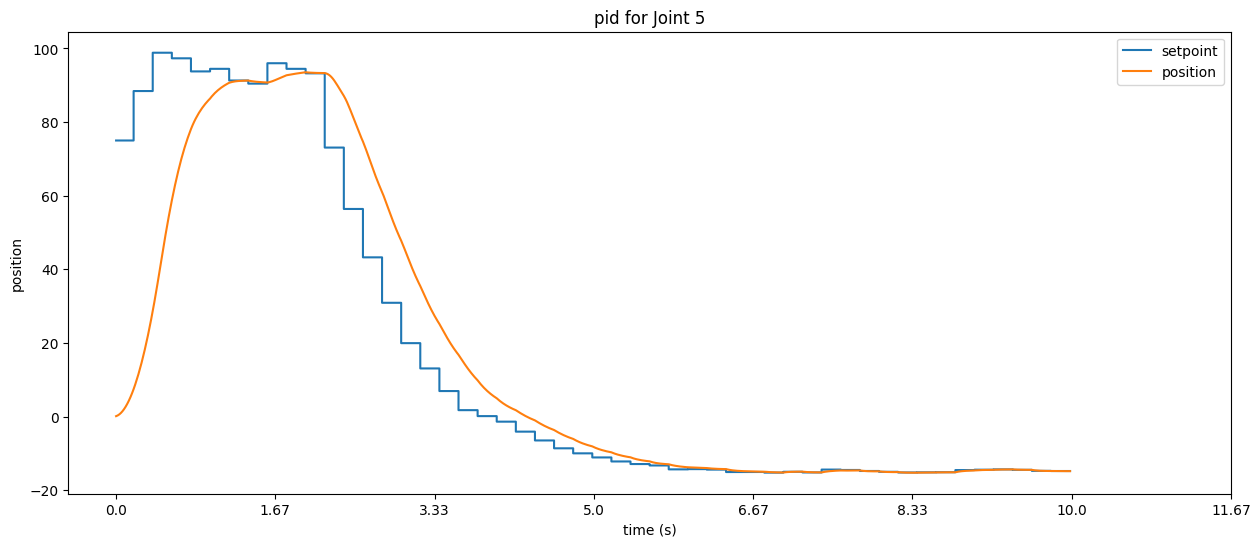

In [51]:
plt.figure(figsize=(15, 6))

sns.lineplot(data=setpoint_history, drawstyle="steps-pre", label="setpoint")
sns.lineplot(data=j5_pos_history, label='position')
#sns.lineplot(data=j5_v_history, label='velocity')
#sns.lineplot(data=j5_a_history, label='acceleration')

ticks, labels = plt.xticks()
plt.xticks(ticks=ticks[1:], labels=np.round(ticks[1:] * dt, 2))
plt.xlabel("time (s)")
plt.ylabel("position")
plt.legend()
plt.title("pid for Joint 5")
plt.show()

# Tuning for Joint 6

In [69]:
angles_j6_setpoint = angles_df["smooth_joint_6"].values

j6_Kp = 40
j6_Ki = 70
j6_Kd = 15
dt = 1 / 60

second = 10
fps_update = 60
fps_streaming = 5
loop_time = second * fps_update

current_frame = 0
setpoint = angles_j6_setpoint[current_frame]
j6_pid = Angle_PID(Kp=j6_Kp, Ki=j6_Ki, Kd=j6_Kd, setpoint=setpoint,
    v_max=joint6_max_velo, a_max=joint6_max_acce, dt=dt)
j6_current = 0

j6_pos_history = []
j6_v_history = []
j6_a_history = []
setpoint_history = []
frames = []

count = 1

for i in range(loop_time):
    j6_next, j6_a_current = j6_pid.update(j6_current)
    j6_current = j6_next
    j6_pos_history.append(j6_current)
    j6_v_history.append(j6_pid._v_current)
    j6_a_history.append(j6_a_current)
    setpoint_history.append(j6_pid._setpoint)

    # Set new setpoint
    if count * dt >= 1 / fps_streaming:
        current_frame += 1
        setpoint = angles_j6_setpoint[current_frame]
        j6_pid.update_setpoint(setpoint)
        count = 1
    else:
        count += 1

    frames.append(current_frame)

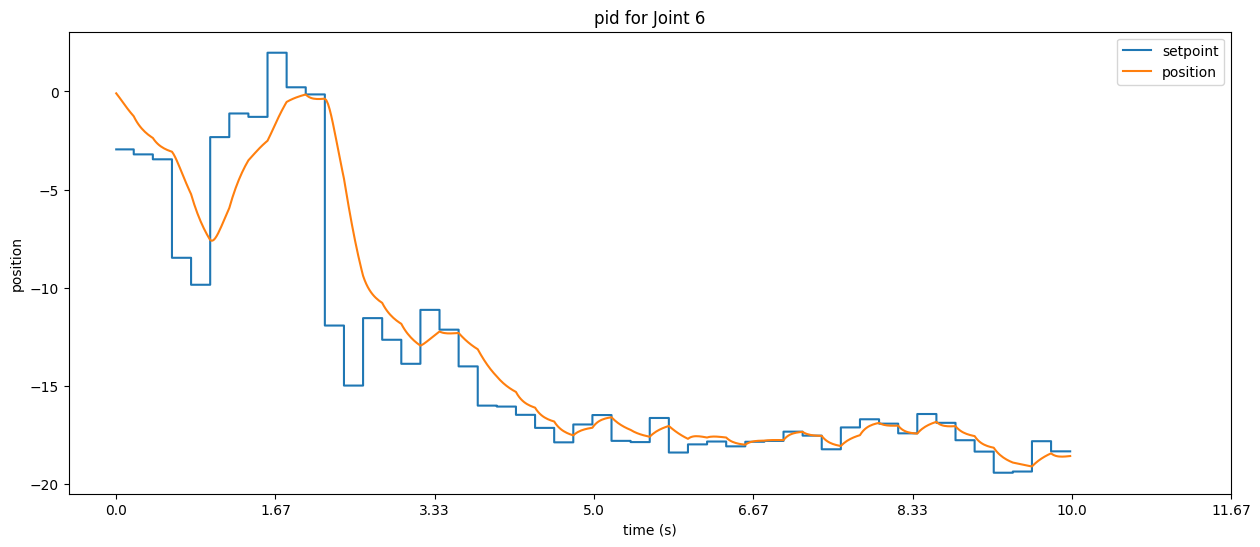

In [70]:
plt.figure(figsize=(15, 6))

sns.lineplot(data=setpoint_history, drawstyle="steps-pre", label="setpoint")
sns.lineplot(data=j6_pos_history, label='position')
#sns.lineplot(data=j6_v_history, label='velocity')
#sns.lineplot(data=j6_a_history, label='acceleration')

ticks, labels = plt.xticks()
plt.xticks(ticks=ticks[1:], labels=np.round(ticks[1:] * dt, 2))
plt.xlabel("time (s)")
plt.ylabel("position")
plt.legend()
plt.title("pid for Joint 6")
plt.show()